# CNF vs RealNVP

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
mlflow.set_experiment('cnf_trace_computation')
from itertools import product
import torch
from datetime import datetime, timezone
import numpy as np
import json

from even_flow.moons.jobs import (
    MoonsTimeEmbeddingMLPCNFJob,
    MoonsRealNVPJob,
    MoonsZukoCNFJob
)
from even_flow.moons.dataset import MoonsDataset
from even_flow.models.cnf import TimeEmbeddingMLPCNFModel, ZukoCNFModel
from even_flow.models.real_nvp import RealNVPModel
from even_flow.utils import set_logger

logger = set_logger()

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'default' attribute with value None was provided to the `Field()` function, which has no effect in the context it was used. 'default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


# Dual Moons

In [2]:
train_samples = 10000
val_samples = 1000
test_samples = 1000
noise = 0.05
batch_size = 32
random_state = 943874

datamodule = MoonsDataset(
    train_samples=train_samples,
    val_samples=val_samples,
    test_samples=test_samples,
    noise=noise,
    batch_size=batch_size,
    random_state=random_state
)

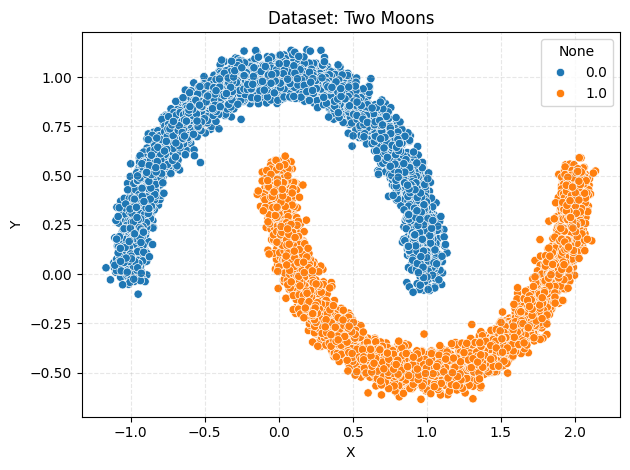

In [3]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    x=datamodule.train_X[:, 0].reshape(-1),
    y=datamodule.train_X[:, 1].reshape(-1),
    hue=datamodule.train_y.reshape(-1),
    ax=ax
)
ax.set(
    title='Dataset: Two Moons',
    xlabel='X',
    ylabel='Y'
)
fig.tight_layout()
moons_xlim = ax.get_xlim()
moons_ylim = ax.get_ylim()

## RealNVP

In [4]:
experiment_name = 'Moons Real NVP'
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/mlruns/425052754478199524', creation_time=1764488699917, experiment_id='425052754478199524', last_update_time=1764488699917, lifecycle_stage='active', name='Moons Real NVP', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [5]:
neuron_options = [
    [64, 64],
    [64, 64, 64, 64],
    [256, 256]
]
activation_options = ['gelu', 'tanh']

In [ ]:
real_nvp_jobs = []
for i, (neurons, activation) in enumerate(product(neuron_options, activation_options)):
    logger.info(
        f'Running job: real-nvp-moons-{i} | Hidden features: {neurons} | Activation: {activation}')
    job = MoonsRealNVPJob(
        name=f'real-nvp-moons-{i}',
        datamodule=datamodule,
        model=RealNVPModel(
            features=2,
            transforms=4,
            hidden_features=neurons,
            checkpoint=dict(
                monitor='val_loss',
                mode='min',
            ),
            early_stopping=dict(
                monitor='val_loss',
                mode='min',
                patience=5,
                min_delta=1e-3
            ),
            learning_rate=1e-3,
            max_epochs=50,
            activation=activation
        )
    )
    job.run()
    real_nvp_jobs.append(job)
    break

In [7]:
# recent_job = real_nvp_jobs[0]
loaded_job = MoonsRealNVPJob.from_mlflow_run_id('cd58cf5bb1f142fabf0c81776d4898e9')

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
experiment = mlflow.get_experiment_by_name(experiment_name)
real_nvp_runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
real_nvp_runs_df = real_nvp_runs_df[real_nvp_runs_df['status'] == 'FINISHED']
real_nvp_runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val.loss,metrics.epoch,metrics.test.eval_start,metrics.val.eval_duration,...,params.datamodule.val_samples,params.model.features,params.model.checkpoint.mode,params.model.early_stopping..mode,params.model.learning_rate,params.model.checkpoint.monitor,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user
0,cd58cf5bb1f142fabf0c81776d4898e9,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:20:32.525000+00:00,2025-12-03 12:21:41.586000+00:00,0.514504,14.0,1.764765e+09,0.042792,...,1000,2,min,min,0.001,val_loss,real-nvp-moons-5,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes
1,1c613db51db541c8a0f60a97d5e275eb,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:19:19.933000+00:00,2025-12-03 12:20:32.518000+00:00,0.495437,14.0,1.764764e+09,0.099905,...,1000,2,min,min,0.001,val_loss,real-nvp-moons-4,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes
2,6cf4cb151460426784dce42dbc8f805e,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:15:48.084000+00:00,2025-12-03 12:19:19.924000+00:00,0.400273,44.0,1.764764e+09,0.110522,...,1000,2,min,min,0.001,val_loss,real-nvp-moons-3,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes
3,a9fe0c487fa64ddca9a0ea71df4d51b9,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:13:58.839000+00:00,2025-12-03 12:15:48.080000+00:00,0.431666,20.0,1.764764e+09,0.051225,...,1000,2,min,min,0.001,val_loss,real-nvp-moons-2,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes
4,90e182e2254f4f549faae06d3404037e,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:12:43.230000+00:00,2025-12-03 12:13:58.833000+00:00,0.428639,18.0,1.764764e+09,0.039202,...,1000,2,min,min,0.001,val_loss,real-nvp-moons-1,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes
5,f67e4fc0da2f41c49f85183978d6a297,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:10:31.931000+00:00,2025-12-03 12:12:43.226000+00:00,0.495816,34.0,1.764764e+09,0.097323,...,1000,2,min,min,0.001,val_loss,real-nvp-moons-0,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes


In [9]:
for i, col in enumerate(real_nvp_runs_df.columns):
    print(f'{i} - {col}')

0 - run_id
1 - experiment_id
2 - status
3 - artifact_uri
4 - start_time
5 - end_time
6 - metrics.val.loss
7 - metrics.epoch
8 - metrics.test.eval_start
9 - metrics.val.eval_duration
10 - metrics.train.eval_end
11 - metrics.train_loss_epoch
12 - metrics.test.eval_duration
13 - metrics.fit_start
14 - metrics.val_loss
15 - metrics.fit_end
16 - metrics.fit_duration
17 - metrics.train.eval_start
18 - metrics.test.eval_end
19 - metrics.exec_end
20 - metrics.test.loss
21 - metrics.exec_start
22 - metrics.exec_duration
23 - metrics.train.eval_duration
24 - metrics.train_loss_step
25 - metrics.val.eval_end
26 - metrics.train.loss
27 - metrics.val.eval_start
28 - params.model.max_epochs
29 - params.model.profiler
30 - params.model.checkpoint.save_top_k
31 - params.datamodule.train_samples
32 - params.model.hidden_features
33 - params.model.num_sanity_val_steps
34 - params.datamodule.batch_size
35 - params.model.checkpoint.filename
36 - params.model.checkpoint.dirpath
37 - params.model.early_stop

### Activation X Test Loss X Hidden Features

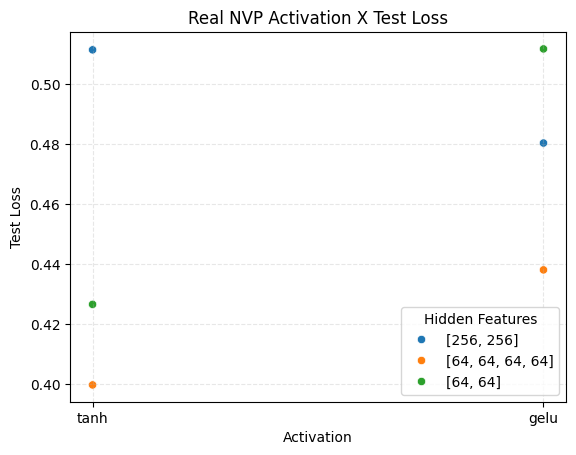

In [10]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    y='metrics.test.loss', 
    x='params.model.activation', 
    data=real_nvp_runs_df,
    hue='params.model.hidden_features',
    ax=ax
)
ax.set(
    xlabel='Activation',
    ylabel='Test Loss',
    title='Real NVP Activation X Test Loss'
)
ax.legend(title='Hidden Features')

### Fit duration

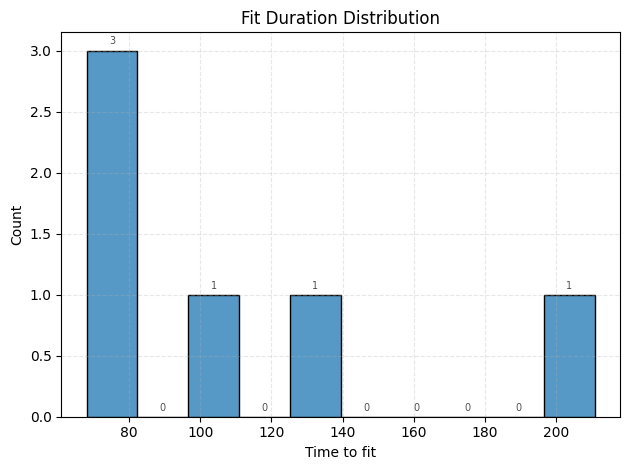

In [11]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    real_nvp_runs_df,
    x='metrics.fit_duration',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=10
)
plt.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3,
              fontsize='x-small', alpha=0.7) 
ax.set_title(
    'Fit Duration Distribution',
    fontsize='large'
)
ax.set_xlabel('Time to fit', fontsize='medium')
fig.tight_layout()

### Min test loss

In [12]:
min_nvp_idx = real_nvp_runs_df['metrics.test.loss'].idxmin()
min_nvp_run = real_nvp_runs_df.loc[min_nvp_idx]
min_nvp_job = MoonsRealNVPJob.from_mlflow_run_id(min_nvp_run['run_id'])
min_nvp_job

MoonsRealNVPJob(id_='6cf4cb151460426784dce42dbc8f805e', name='real-nvp-moons-3', model=RealNVPModel(id_='6cf4cb151460426784dce42dbc8f805e', name='real-nvp-moons-3', prefix='model', accelerator='cpu', profiler='simple', max_epochs=50, verbose=True, num_sanity_val_steps=5, checkpoint=ModelCheckpointConfig(id_='6cf4cb151460426784dce42dbc8f805e', name='real-nvp-moons-3', prefix='model.checkpoint', dirpath=None, monitor='val_loss', mode='min', save_top_k=3, filename='checkpoint-{epoch:02d}-{val_loss:.2f}'), early_stopping=EarlyStoppingConfig(id_='6cf4cb151460426784dce42dbc8f805e', name='real-nvp-moons-3', prefix='model.early_stopping', monitor='val_loss', patience=3, min_delta=0.001, mode='min', stopping_threshold=None), lightning_module=RealNVPModule(
  (model): RealNVP(
    (transform): LazyComposedTransform(
      (0): GeneralCouplingTransform(
        (base): MonotonicAffineTransform()
        (mask): [1, 0]
        (hyper): MLP(
          (0): Linear(in_features=1, out_features=64, bia

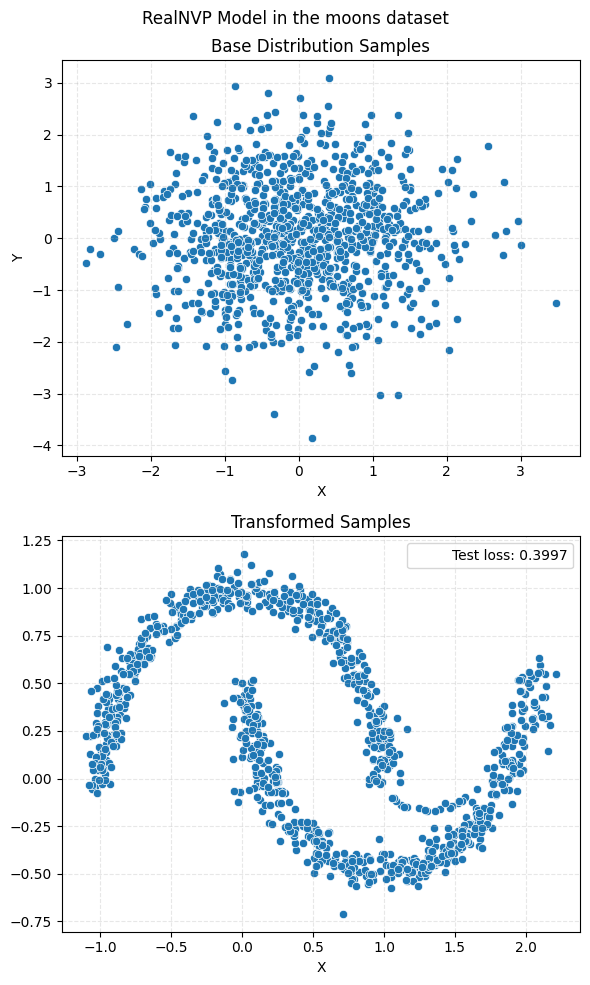

In [13]:
sample_time_estimation = 100
n_samples = 1000
# delta = []
# for _ in range(sample_time_estimation):
#     start = datetime.now(timezone.utc).timestamp()
#     min_nvp_job.model.sample((n_samples,))
#     finish = datetime.now(timezone.utc).timestamp()
#     delta.append(finish - start)
# delta = np.array(delta)
# avg = np.mean(delta)
# std = np.std(delta)
# logger.info(f'Average sampling time over {sample_time_estimation} runs: {avg:.5f} ± {std:.5f} seconds')

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
transformed_samples, base_samples, fig, axes = min_nvp_job.plot_comparison(n_samples=n_samples, axes=axes)
fig.suptitle('RealNVP Model in the moons dataset')
fig.tight_layout()
axes[1].plot([], [], ' ',
             label=f'Test loss: {min_nvp_run["metrics.test.loss"]:.4f}',)
axes[1].legend()

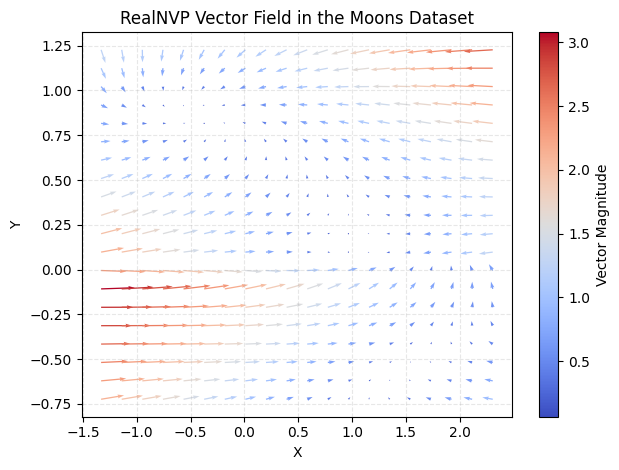

In [13]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
min_nvp_job.vector_field_plot(
    x=torch.linspace(moons_xlim[0], moons_xlim[1], 20),
    y=torch.linspace(moons_ylim[0], moons_ylim[1], 20),
    ax=ax,
    cmap='coolwarm'
)
ax.set(
    xlabel='X', ylabel='Y',
    title='RealNVP Vector Field in the Moons Dataset'
)
fig.tight_layout()

## Exact CNF

In [14]:
experiment_name = 'Moons Zuko CNF Exact'
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/mlruns/318979348285482367', creation_time=1764722403179, experiment_id='318979348285482367', last_update_time=1764722403179, lifecycle_stage='active', name='Moons Zuko CNF Exact', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [15]:
exact_cnf_jobs = []
for i, (activation, neurons_per_layer) in enumerate(product(activation_options, neuron_options)):
    logger.info(f'Running job: exact-cnf-moons-{i}')
    job = MoonsZukoCNFJob(
        name=f'zuko-exact-cnf-moons-{i}',
        datamodule=datamodule,
        model=ZukoCNFModel(
            features=2,
            hidden_features=neurons_per_layer,
            activation=activation,
            exact=True,
            max_epochs=50,
            checkpoint=dict(
                monitor='val_loss',
                mode='min',
            ),
            early_stopping=dict(
                monitor='val_loss',
                mode='min',
                patience=3,
                min_delta=1e-2
            ),
        )
    )
    job.run()
    exact_cnf_jobs.append(job)

2025-12-03 09:21:42 | INFO | root | 250163934 | 3 | Running job: exact-cnf-moons-0
2025-12-03 09:21:42 | INFO | even_flow | jobs | 67 | Fitting model...
2025-12-03 09:21:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-03 09:21:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CNF              | 4.9 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 22: 100%|██████████| 313/313 [01:36<00:00,  3.23it/s, v_num=e0ad, train_loss_step=0.137, val_loss=0.344, train_loss_epoch=0.358]


2025/12/03 09:54:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/03 09:54:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-03 09:54:19 | INFO | even_flow | jobs | 99 | Evaluating model on train dataset


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/core/module.py:449: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


2025-12-03 09:54:57 | INFO | even_flow | jobs | 99 | Evaluating model on val dataset
2025-12-03 09:55:02 | INFO | even_flow | jobs | 99 | Evaluating model on test dataset
2025-12-03 09:55:06 | INFO | root | 250163934 | 3 | Running job: exact-cnf-moons-1
2025-12-03 09:55:06 | INFO | even_flow | jobs | 67 | Fitting model...
2025-12-03 09:55:06 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-03 09:55:06 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CNF              | 13.2 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 313/313 [02:19<00:00,  2.24it/s, v_num=b5a9, train_loss_step=0.376, val_loss=0.441, train_loss_epoch=0.439]


2025/12/03 10:14:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/03 10:14:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-03 10:14:08 | INFO | even_flow | jobs | 99 | Evaluating model on train dataset
2025-12-03 10:15:02 | INFO | even_flow | jobs | 99 | Evaluating model on val dataset
2025-12-03 10:15:08 | INFO | even_flow | jobs | 99 | Evaluating model on test dataset
2025-12-03 10:15:14 | INFO | root | 250163934 | 3 | Running job: exact-cnf-moons-2
2025-12-03 10:15:14 | INFO | even_flow | jobs | 67 | Fitting model...
2025-12-03 10:15:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-03 10:15:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CNF              | 68.6 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
68.6 K    Trainable params
0         Non-trainable params
68.6 K    Total params
0.274     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 313/313 [01:53<00:00,  2.75it/s, v_num=85fe, train_loss_step=0.173, val_loss=0.355, train_loss_epoch=0.391]


2025/12/03 10:39:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/03 10:39:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-03 10:39:06 | INFO | even_flow | jobs | 99 | Evaluating model on train dataset
2025-12-03 10:39:45 | INFO | even_flow | jobs | 99 | Evaluating model on val dataset
2025-12-03 10:39:50 | INFO | even_flow | jobs | 99 | Evaluating model on test dataset
2025-12-03 10:39:52 | INFO | root | 250163934 | 3 | Running job: exact-cnf-moons-3
2025-12-03 10:39:52 | INFO | even_flow | jobs | 67 | Fitting model...
2025-12-03 10:39:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-03 10:39:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CNF              | 4.9 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 27: 100%|██████████| 313/313 [02:06<00:00,  2.47it/s, v_num=a32d, train_loss_step=0.127, val_loss=0.433, train_loss_epoch=0.412]


2025/12/03 11:18:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/03 11:18:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-03 11:18:20 | INFO | even_flow | jobs | 99 | Evaluating model on train dataset
2025-12-03 11:18:55 | INFO | even_flow | jobs | 99 | Evaluating model on val dataset
2025-12-03 11:18:58 | INFO | even_flow | jobs | 99 | Evaluating model on test dataset
2025-12-03 11:19:02 | INFO | root | 250163934 | 3 | Running job: exact-cnf-moons-4
2025-12-03 11:19:02 | INFO | even_flow | jobs | 67 | Fitting model...
2025-12-03 11:19:02 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-03 11:19:02 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CNF              | 13.2 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 313/313 [03:57<00:00,  1.32it/s, v_num=509e, train_loss_step=0.295, val_loss=0.453, train_loss_epoch=0.460]


2025/12/03 12:01:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/03 12:01:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-03 12:01:32 | INFO | even_flow | jobs | 99 | Evaluating model on train dataset
2025-12-03 12:02:48 | INFO | even_flow | jobs | 99 | Evaluating model on val dataset
2025-12-03 12:02:56 | INFO | even_flow | jobs | 99 | Evaluating model on test dataset
2025-12-03 12:03:04 | INFO | root | 250163934 | 3 | Running job: exact-cnf-moons-5
2025-12-03 12:03:04 | INFO | even_flow | jobs | 67 | Fitting model...
2025-12-03 12:03:04 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-03 12:03:04 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CNF              | 68.6 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
68.6 K    Trainable params
0         Non-trainable params
68.6 K    Total params
0.274     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0:  79%|███████▉  | 248/313 [1:20:27<21:05,  0.05it/s, v_num=d870, train_loss_step=1.670]2025-12-03 13:23:33 | INFO | pytorch_lightning.utilities.rank_zero | call | 58 | 
Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [16]:
experiment = mlflow.get_experiment_by_name(experiment_name)
exact_cnf_runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
exact_cnf_runs_df = exact_cnf_runs_df[exact_cnf_runs_df['status'] == 'FINISHED']
exact_cnf_runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.fit_start,metrics.epoch,metrics.exec_start,metrics.train_loss_step,...,params.model.accelerator,params.datamodule.train_samples,params.model.rtol,params.datamodule.random_state,params.model.checkpoint.save_top_k,params.datamodule.val_samples,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName
1,f4a7a0cac7e44a7eb784f67612d0509e,318979348285482367,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 14:19:02.618000+00:00,2025-12-03 15:03:04.786000+00:00,1.764772e+09,12.0,1.764772e+09,0.547394,...,cpu,10000,1e-05,943874,3,1000,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,zuko-exact-cnf-moons-4
2,c106942353f1475597f4c3ed8da3a32d,318979348285482367,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 13:39:52.186000+00:00,2025-12-03 14:19:02.614000+00:00,1.764769e+09,27.0,1.764769e+09,0.263460,...,cpu,10000,1e-05,943874,3,1000,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,zuko-exact-cnf-moons-3
3,e6d78532980a41ed8cba2408959e85fe,318979348285482367,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 13:15:14.522000+00:00,2025-12-03 13:39:52.183000+00:00,1.764768e+09,12.0,1.764768e+09,0.377668,...,cpu,10000,1e-05,943874,3,1000,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,zuko-exact-cnf-moons-2
4,b70dbfcb14a34d35942079f9924eb5a9,318979348285482367,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:55:06.042000+00:00,2025-12-03 13:15:14.517000+00:00,1.764767e+09,8.0,1.764767e+09,0.555248,...,cpu,10000,1e-05,943874,3,1000,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,zuko-exact-cnf-moons-1
5,0a126e6db3694bf59e32afc40282e0ad,318979348285482367,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-03 12:21:42.507000+00:00,2025-12-03 12:55:06.037000+00:00,1.764765e+09,22.0,1.764765e+09,0.577923,...,cpu,10000,1e-05,943874,3,1000,LOCAL,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,zuko-exact-cnf-moons-0


In [17]:
for i, col in enumerate(exact_cnf_runs_df.columns):
    print(f'{i} - {col}')

0 - run_id
1 - experiment_id
2 - status
3 - artifact_uri
4 - start_time
5 - end_time
6 - metrics.fit_start
7 - metrics.epoch
8 - metrics.exec_start
9 - metrics.train_loss_step
10 - metrics.val.eval_end
11 - metrics.train.eval_start
12 - metrics.fit_duration
13 - metrics.train_loss_epoch
14 - metrics.exec_duration
15 - metrics.test.eval_start
16 - metrics.test.eval_end
17 - metrics.test.eval_duration
18 - metrics.fit_end
19 - metrics.val.loss
20 - metrics.exec_end
21 - metrics.val.eval_duration
22 - metrics.train.eval_end
23 - metrics.train.eval_duration
24 - metrics.train.loss
25 - metrics.val.eval_start
26 - metrics.val_loss
27 - metrics.test.loss
28 - params.model.num_sanity_val_steps
29 - params.model.checkpoint.monitor
30 - params.model.checkpoint.dirpath
31 - params.model.early_stopping..patience
32 - params.model.activation
33 - params.model.checkpoint.filename
34 - params.model.early_stopping..mode
35 - params.model.freqs
36 - params.model.hidden_features
37 - params.datamodule.

In [ ]:
exact_cnf_jobs = [
    MoonsZukoCNFJob.from_mlflow_run_id(run_id=row['run_id'])
    for _, row in exact_cnf_runs_df.iterrows()
]
print(f'Loaded {len(exact_cnf_jobs)} exact CNF jobs from MLflow.')

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Loaded 6 exact CNF jobs from MLflow.


### Activations X Test Loss X Neurons per Layer

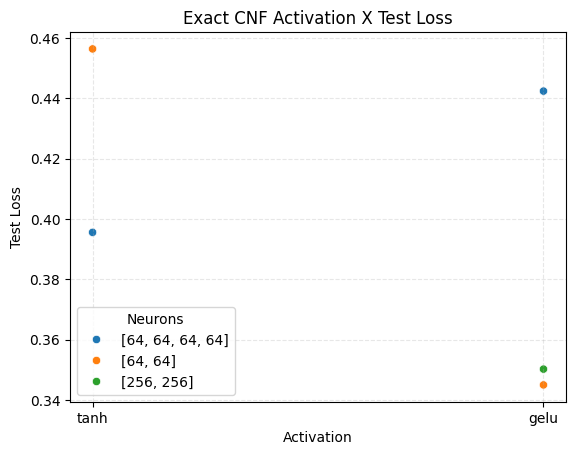

In [18]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    y='metrics.test.loss', 
    x='params.model.activation', 
    data=exact_cnf_runs_df,
    hue='params.model.hidden_features',
    ax=ax
)
ax.set(
    xlabel='Activation',
    ylabel='Test Loss',
    title='Exact CNF Activation X Test Loss'
)
ax.legend(title='Neurons')

### Fit duration

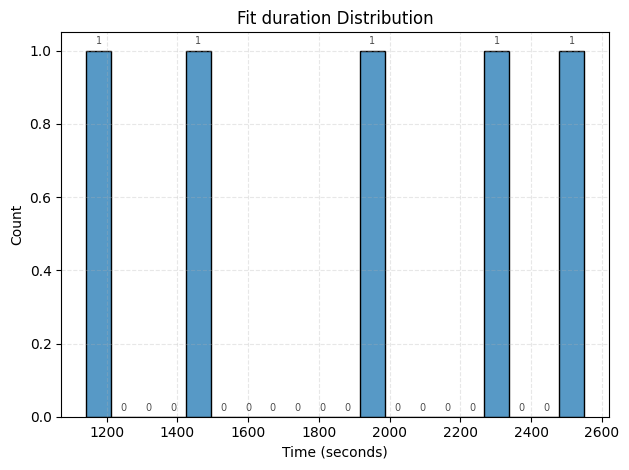

In [19]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    exact_cnf_runs_df,
    x='metrics.fit_duration',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
plt.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3,
              fontsize='x-small', alpha=0.7) 
ax.set_title(
    'Fit duration Distribution',
    fontsize='large'
)
ax.set_xlabel('Time (seconds)', fontsize='medium')
fig.tight_layout()

### Min test loss

In [20]:
min_exact_cnf_idx = exact_cnf_runs_df['metrics.test.loss'].idxmin()
min_exact_cnf_run = exact_cnf_runs_df.loc[min_exact_cnf_idx]
for job in exact_cnf_jobs:
    if job.id_ == min_exact_cnf_run['run_id']:
        min_exact_cnf_job = job
        break
min_exact_cnf_job

MoonsZukoCNFJob(id_='0a126e6db3694bf59e32afc40282e0ad', name='zuko-exact-cnf-moons-0', model=ZukoCNFModel(id_=None, name=None, prefix='', accelerator='cpu', profiler='simple', max_epochs=50, verbose=True, num_sanity_val_steps=5, checkpoint=ModelCheckpointConfig(id_=None, name=None, prefix='', dirpath=None, monitor='val_loss', mode='min', save_top_k=3, filename='checkpoint-{epoch:02d}-{val_loss:.2f}'), early_stopping=EarlyStoppingConfig(id_=None, name=None, prefix='', monitor='val_loss', patience=3, min_delta=0.01, mode='min', stopping_threshold=None), features=2, context=0, freqs=3, atol=1e-05, rtol=1e-05, exact=True, learning_rate=0.001, hidden_features=[64, 64], activation='gelu'), datamodule=<even_flow.moons.dataset.MoonsDataset object at 0x76ecff005ca0>, metrics={'train': {'loss': 0.3494112193584442}, 'val': {'loss': 0.34366661310195923}, 'test': {'loss': 0.3449905812740326}, 'predict': {}})

2025-12-03 13:25:12 | INFO | root | 689982175 | 12 | Average sampling time over 100 runs: 0.17142 ± 0.06739 seconds


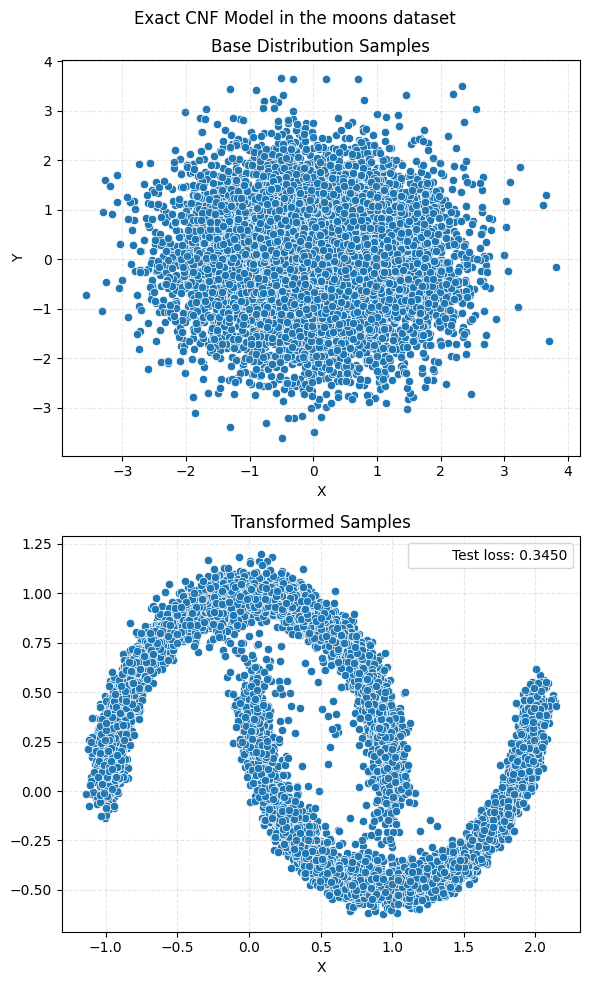

In [22]:
sample_time_estimation = 100
n_samples = 10000
delta = []
for _ in range(sample_time_estimation):
    start = datetime.now(timezone.utc).timestamp()
    min_exact_cnf_job.model.sample((n_samples,))
    finish = datetime.now(timezone.utc).timestamp()
    delta.append(finish - start)
delta = np.array(delta)
avg = np.mean(delta)
std = np.std(delta)
logger.info(f'Average sampling time over {sample_time_estimation} runs: {avg:.5f} ± {std:.5f} seconds')

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
transformed_samples, base_samples, fig, axes = min_exact_cnf_job.plot_comparison(n_samples=n_samples, axes=axes)
fig.suptitle('Exact CNF Model in the moons dataset')
fig.tight_layout()
axes[1].plot([], [], ' ',
             label=f'Test loss: {min_exact_cnf_run["metrics.test.loss"]:.4f}',)
axes[1].legend()

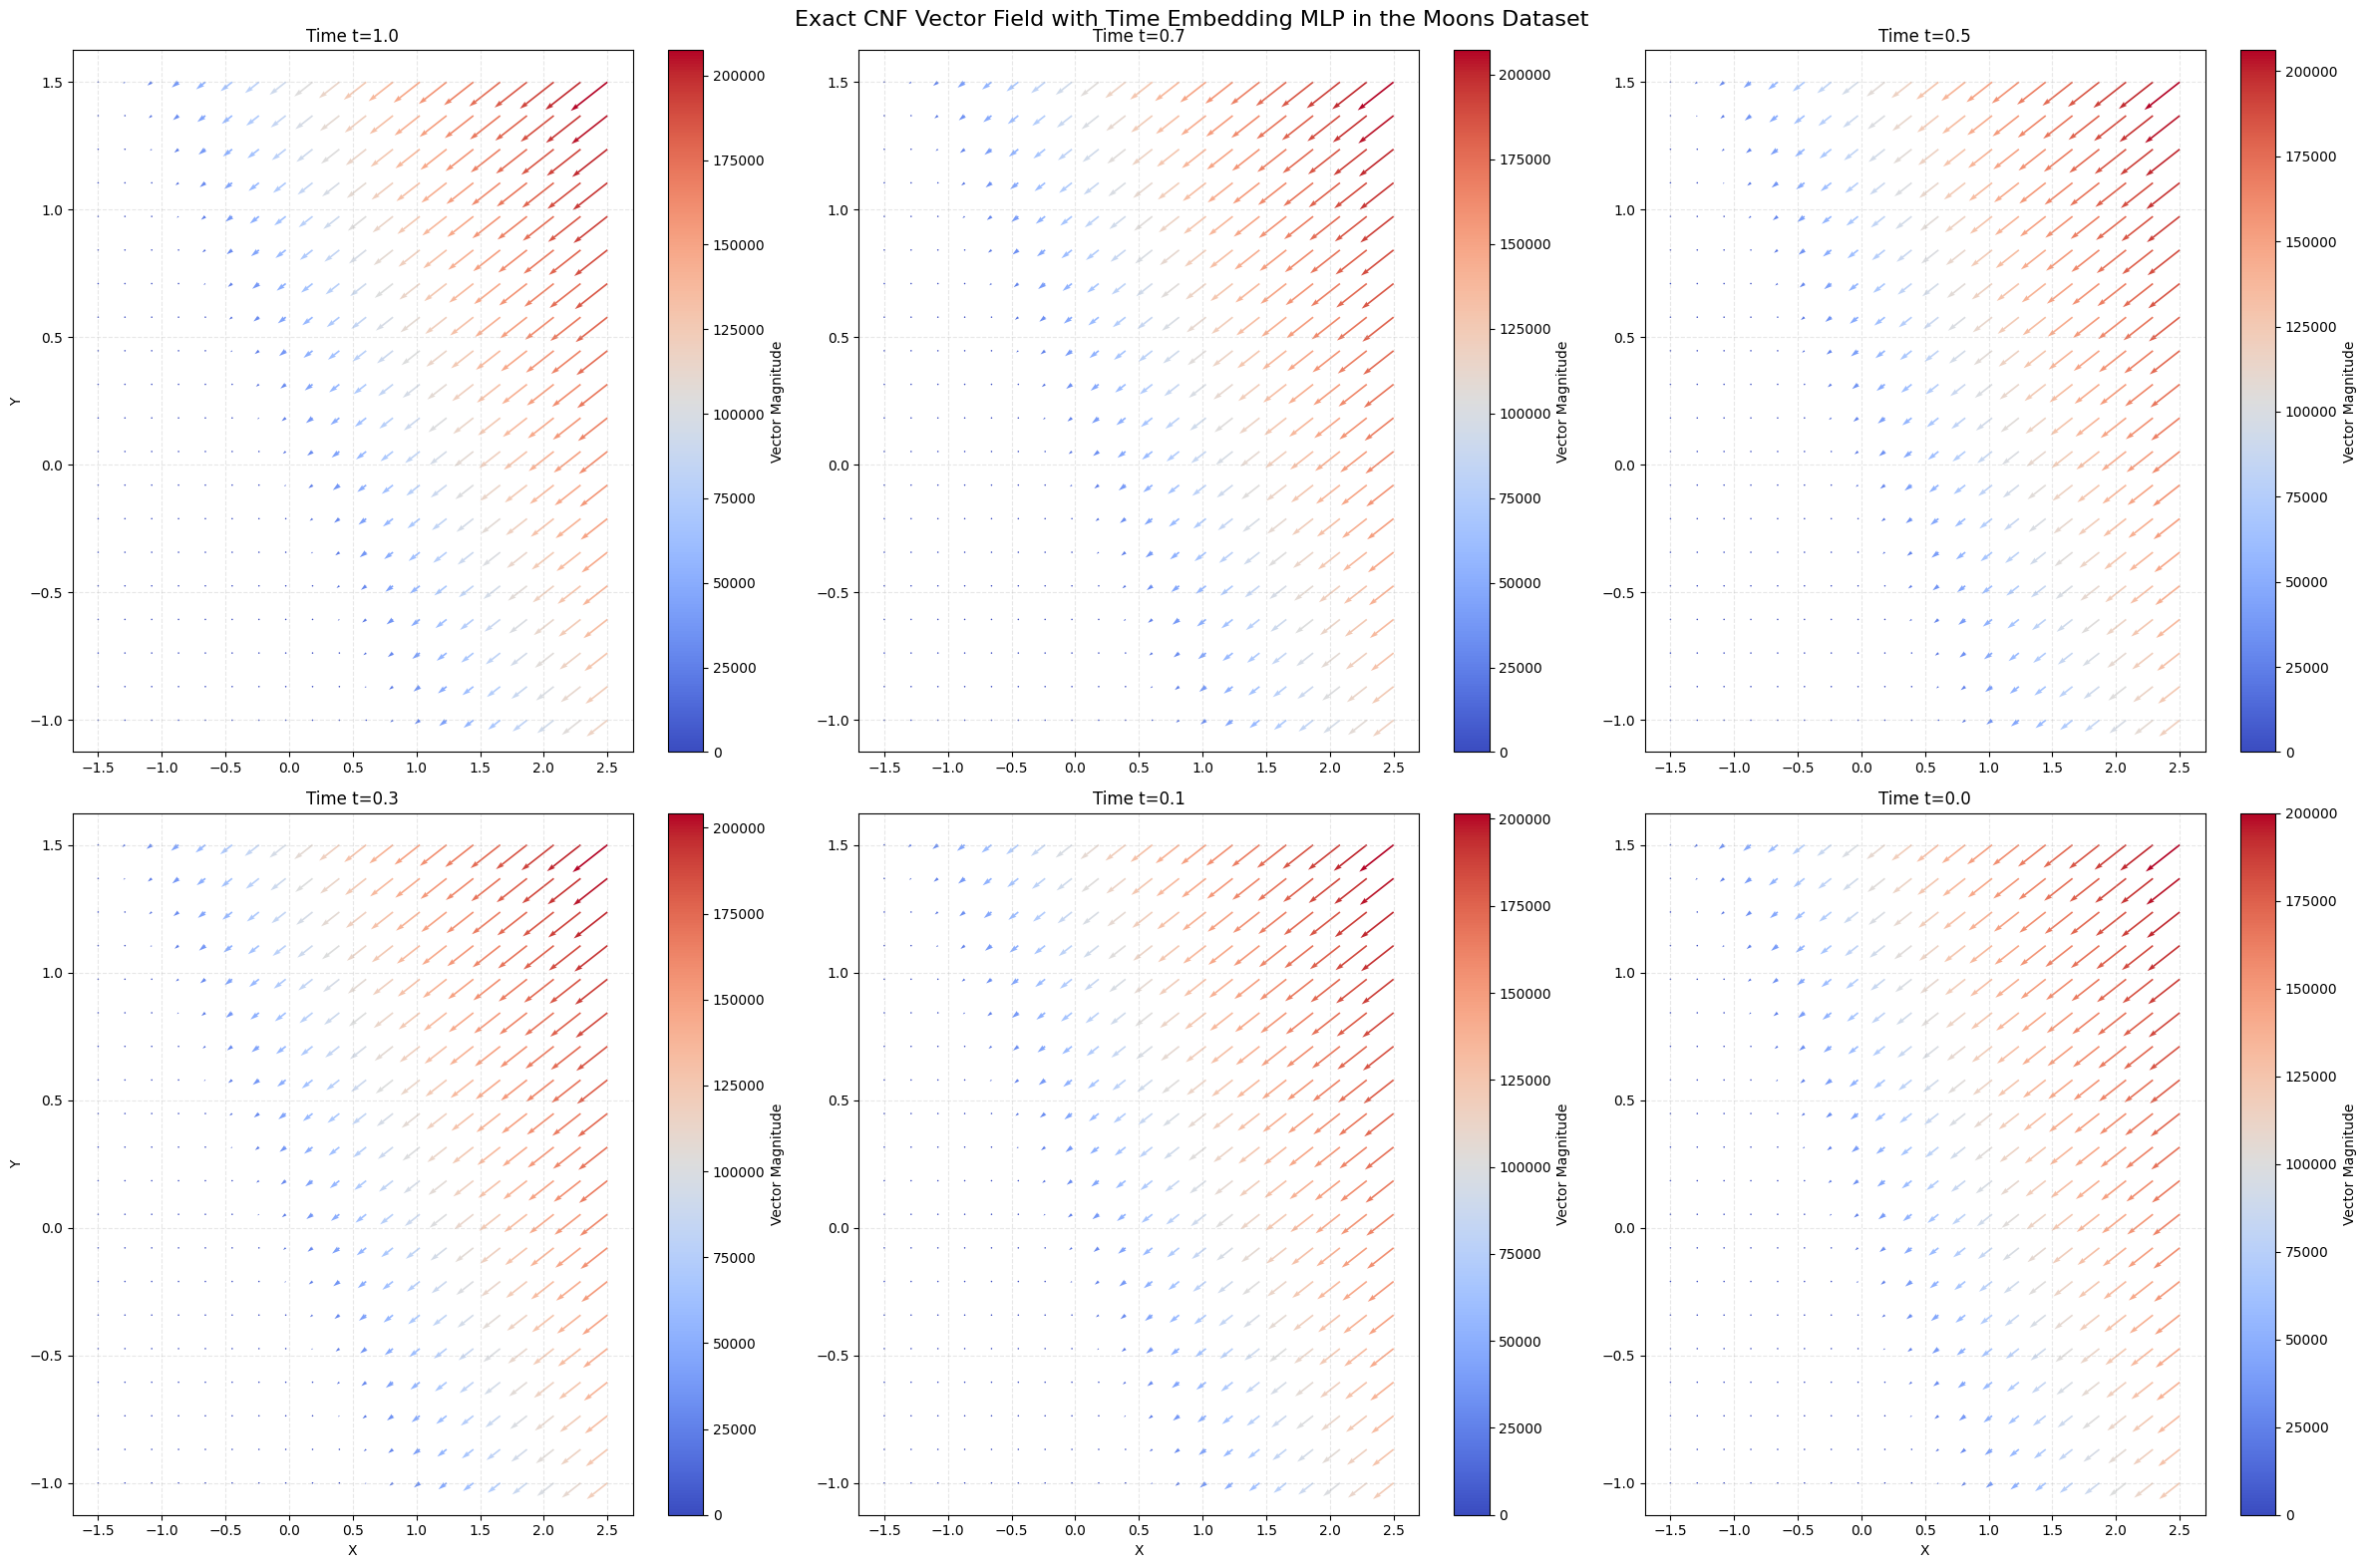

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
for ax in axes[-1, :].flatten():
    ax.set_xlabel('X')
for ax in axes[:, 0].flatten():
    ax.set_ylabel('Y')
times = [1.0, 0.7, 0.5, 0.3, 0.1, 0.0]
for t, ax in zip(times, axes.flatten()):
    ax.set_title(f'Time t={t}') 
    ax.grid(alpha=.3, linestyle='--')
    min_exact_cnf_job.vector_field_plot(
        x=torch.linspace(-1.5, 2.5, 20),
        y=torch.linspace(-1.0, 1.5, 20),
        t=t,
        ax=ax,
        cmap='coolwarm'
    )
fig.suptitle('Exact CNF Vector Field with Time Embedding MLP in the Moons Dataset', fontsize=16)
fig.tight_layout()